In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import time
# preprocessing and pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from outlier_cleaner import OutlierCleaner



# sklearn libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
    VotingRegressor, StackingRegressor, RandomForestClassifier, VotingClassifier
)

# sklearn metrics
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report, precision_score
from extended_sklearn_metrics import evaluate_model_with_cross_validation

# extra model
import xgboost as xgb

import joblib

In [42]:
df = pd.read_csv('heart_attack_prediction_indonesia.csv', nrows=30000)
# df.columns

In [43]:
df.columns.tolist()

['age',
 'gender',
 'region',
 'income_level',
 'hypertension',
 'diabetes',
 'cholesterol_level',
 'obesity',
 'waist_circumference',
 'family_history',
 'smoking_status',
 'alcohol_consumption',
 'physical_activity',
 'dietary_habits',
 'air_pollution_exposure',
 'stress_level',
 'sleep_hours',
 'blood_pressure_systolic',
 'blood_pressure_diastolic',
 'fasting_blood_sugar',
 'cholesterol_hdl',
 'cholesterol_ldl',
 'triglycerides',
 'EKG_results',
 'previous_heart_disease',
 'medication_usage',
 'participated_in_free_screening',
 'heart_attack']

## Feature Engineering (higher values = more risk)

In [44]:
# df.columns.tolist()

In [45]:
df['alcohol_consumption'] = df['alcohol_consumption'].fillna('None')
stress_mapping = {
    'Low': 1,        
    'Moderate': 2,   
    'High': 3        
}
df['stress_level'] = df['stress_level'].map(stress_mapping)
smoking_mapping = {
    'Never': 1, 
    'Past': 2, 
    'Current': 3  
}
df['smoking_status'] = df['smoking_status'].map(smoking_mapping)
alcohol_consumption_mapping = {
    'None': 1, 
    'Moderate': 2, 
    'High': 3  
}
df['alcohol_consumption'] = df['alcohol_consumption'].map(alcohol_consumption_mapping)
physical_activity_mapping = {
    'Low': 1, 
    'Moderate': 2, 
    'High': 3  
}
df['physical_activity'] = df['physical_activity'].map(physical_activity_mapping)
dietary_habits_mapping = {
    'Unhealthy': 1, 
    'Healthy': 2, 
}
df['dietary_habits'] = df['dietary_habits'].map(dietary_habits_mapping)
air_pollution_mapping = {
    'Low': 1, 
    'Moderate': 2, 
    'High': 3  
}
df['air_pollution_exposure'] = df['air_pollution_exposure'].map(air_pollution_mapping)
income_level_mapping = {
    'Low': 3, 
    'Middle': 2, 
    'High': 1  
}
df['income_level'] = df['income_level'].map(income_level_mapping)
df['age_group'] = np.where(
    df['age'] < 40, 1, np.where(
        df['age'] < 55, 2, np.where(
            df['age'] < 64, 3, np.where(
                df['age'] < 65, 4, 5
            )
        )
    )
)


In [46]:
columns_to_check = [
    'hypertension',
    'diabetes',
    'obesity',
    'family_history',
    'smoking_status',
    'alcohol_consumption',
    'physical_activity',
    'dietary_habits',
    'air_pollution_exposure',
    'stress_level',
    'income_level'    
]

# Display the data types of these columns
print(df[columns_to_check].dtypes)

hypertension              int64
diabetes                  int64
obesity                   int64
family_history            int64
smoking_status            int64
alcohol_consumption       int64
physical_activity         int64
dietary_habits            int64
air_pollution_exposure    int64
stress_level              int64
income_level              int64
dtype: object


In [47]:
df['health_risk_score'] = (
    df['hypertension'] +
    df['diabetes'] +
    df['obesity'] +
    df['family_history'] +
    df['smoking_status'] +
    df['alcohol_consumption'] +
    (1 - df['physical_activity']) +
    (1 - df['dietary_habits']) +
    df['air_pollution_exposure'] +
    df['stress_level'] +
    df.income_level
)

# df['cholesterol ratio'] = df['cholesterol_hdl']/df['cholesterol_ldl']
# df = df.drop(labels=['cholesterol_hdl', 'cholesterol_ldl'], axis=1)
df['obesity_risk_score'] = np.where(df['gender'] == 'Male' , df['obesity'] * 1 + (df['waist_circumference'] > 102) * 0.5, df['obesity'] * 1 + (df['waist_circumference'] > 88) * 0.5)
df = df.drop(labels=['obesity', 'waist_circumference'], axis=1)
# df['pulse_pressure'] = df['blood_pressure_systolic'] - df['blood_pressure_diastolic']
# df = df.drop(labels=['blood_pressure_systolic', 'blood_pressure_diastolic'], axis=1)
df['stress_to_sleep_ratio'] = df['stress_level'] / df['sleep_hours']
df = df.drop(columns=['stress_level', 'sleep_hours'])
df['mean_arterial_pressure'] = (2* df['blood_pressure_systolic'] + df['blood_pressure_diastolic']) / 3 
df = df.drop(columns=['blood_pressure_systolic', 'blood_pressure_diastolic'])
df['triglyceride-hdl-ratio'] = df['triglycerides'] / df['cholesterol_hdl']
df = df.drop(columns=['triglycerides', 'cholesterol_hdl'])


In [48]:
df_risk_score = df[['health_risk_score','hypertension', 'diabetes', 'obesity_risk_score', 'family_history', 'smoking_status', 'alcohol_consumption', 'physical_activity', 'dietary_habits', 'air_pollution_exposure', 'income_level']]
df_risk_score.corr().sort_values(by='health_risk_score', ascending=False).style.background_gradient(cmap='coolwarm')

,health_risk_score,hypertension,diabetes,obesity_risk_score,family_history,smoking_status,alcohol_consumption,physical_activity,dietary_habits,air_pollution_exposure,income_level
health_risk_score,1.000000,0.221022,0.200788,0.195516,0.232022,0.409907,0.320448,-0.368383,-0.240003,0.344575,0.334245
smoking_status,0.409907,0.002763,0.005988,-0.000811,0.010115,1.000000,-0.000448,-0.002681,0.001074,-0.005643,-0.000080
air_pollution_exposure,0.344575,0.001105,-0.005443,0.000405,-0.000389,-0.005643,0.012482,0.001848,0.006929,1.000000,0.001151
income_level,0.334245,-0.001251,0.000979,-0.002277,-0.003913,-0.000080,-0.012495,0.000417,0.001461,0.001151,1.000000
alcohol_consumption,0.320448,-0.002119,-0.001960,-0.000560,-0.002872,-0.000448,1.000000,0.001925,0.005612,0.012482,-0.012495
family_history,0.232022,-0.001835,-0.001376,0.012271,1.000000,0.010115,-0.002872,-0.005069,-0.006070,-0.000389,-0.003913
hypertension,0.221022,1.000000,-0.001013,-0.002691,-0.001835,0.002763,-0.002119,0.003731,0.001737,0.001105,-0.001251
diabetes,0.200788,-0.001013,1.000000,-0.007008,-0.001376,0.005988,-0.001960,-0.014860,-0.002607,-0.005443,0.000979
obesity_risk_score,0.195516,-0.002691,-0.007008,1.000000,0.012271,-0.000811,-0.000560,0.000576,-0.009096,0.000405,-0.002277
dietary_habits,-0.240003,0.001737,-0.002607,-0.009096,-0.006070,0.001074,0.005612,-0.001255,1.000000,0.006929,0.001461


In [49]:
df = df.drop(columns=['physical_activity', 'dietary_habits',])

In [50]:
df.isna().any()

age                               False
gender                            False
region                            False
income_level                      False
hypertension                      False
diabetes                          False
cholesterol_level                 False
family_history                    False
smoking_status                    False
alcohol_consumption               False
air_pollution_exposure            False
fasting_blood_sugar               False
cholesterol_ldl                   False
EKG_results                       False
previous_heart_disease            False
medication_usage                  False
participated_in_free_screening    False
heart_attack                      False
age_group                         False
health_risk_score                 False
obesity_risk_score                False
stress_to_sleep_ratio             False
mean_arterial_pressure            False
triglyceride-hdl-ratio            False
dtype: bool

In [51]:
df.health_risk_score.unique()

array([ 7, 11,  9, 12, 10, 14,  8, 13,  6,  5,  4, 15,  3, 17, 16],
      dtype=int64)

## Encoding

In [52]:
## Encoding
cat_df = df.select_dtypes(include='object')
num_df = df.select_dtypes(exclude='object')
encoder = LabelEncoder()
for cols in cat_df:
    cat_df[cols+'_encoded'] = encoder.fit_transform(cat_df[cols])
cat_df = cat_df.select_dtypes(exclude='object')
df = pd.concat([cat_df, num_df], axis=1)

## Cleaning Outliers

In [53]:
# cleaner = OutlierCleaner(df, preserve_index=True)
# for column in df:
#     analysis = cleaner.analyze_distribution(column)
#     print(f"\n{column} Analysis:")
#     print(f"- Skewness: {analysis['skewness']:.2f}")
#     print(f"- Recommended method: {analysis['recommended_method']}")

In [54]:
cleaner = OutlierCleaner(df, preserve_index=True)
cleaned_df, info = cleaner.clean_columns(
    method='zscore',
    show_progress=True
)
# cleaned_df

Cleaning columns: 100%|██████████| 24/24 [00:00<00:00, 301.87it/s]


In [55]:
df = cleaned_df

## Visualization of correlation of features with heart attack 

In [56]:
corr_df = df.corr()[['heart_attack']].sort_values(by='heart_attack', ascending=False)
corr_df.style.background_gradient(cmap='coolwarm', axis=None)

,heart_attack
heart_attack,1.000000
previous_heart_disease,0.281407
hypertension,0.266971
health_risk_score,0.196535
diabetes,0.188863
obesity_risk_score,0.151812
smoking_status,0.140622
age_group,0.111207
age,0.104062
cholesterol_level,0.091503


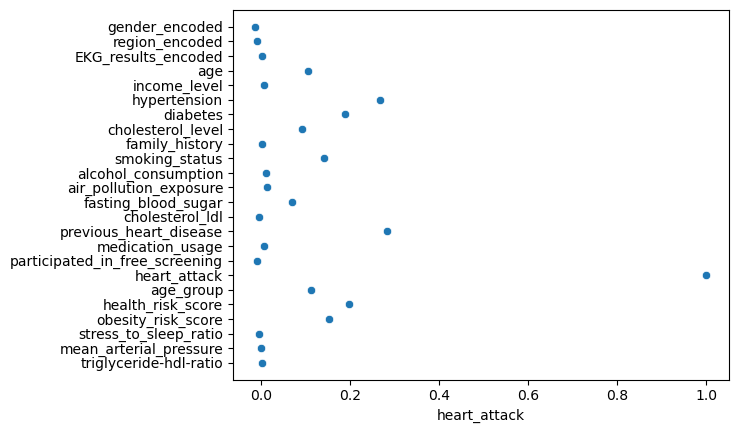

In [57]:
sns.scatterplot(data=df.corr(), x='heart_attack', y=df.columns.tolist())
plt.show()

## Modeling

In [58]:
x = df.drop('heart_attack', axis=1)
y = df['heart_attack']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=23)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)
# X_train_scaled, X_train_scaled[0]
SEED = 42
rf =  RandomForestClassifier(
    criterion='entropy',
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=3,
)
# param_grid = {
#     'classifier__criterion': ['gini', 'entropy', 'log_loss'],
#     'classifier__max_depth': [2,4,5],
#     'classifier__min_samples_split': [2, 3, 4],
#     'classifier__min_samples_leaf': [1, 2, 3],
#     'classifier__max_features': ['sqrt', 'log2'],
# }
# rf_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', rf),
# ])

In [59]:
# grid_search = GridSearchCV(
#     estimator = rf_pipeline,
#     param_grid = param_grid,
#     scoring = 'accuracy',
#     n_jobs = None,
#     cv = 5,
#     verbose = 2,
# )
# grid_search.fit(X_train, y_train)

In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=3)

In [ ]:
# grid_search.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 5,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 3}

In [63]:
# best_model = grid_search.best_estimator_
y_pred = rf.predict(X_test)

In [65]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.89      0.79      5173
           1       0.75      0.48      0.59      3533

    accuracy                           0.73      8706
   macro avg       0.73      0.69      0.69      8706
weighted avg       0.73      0.73      0.71      8706



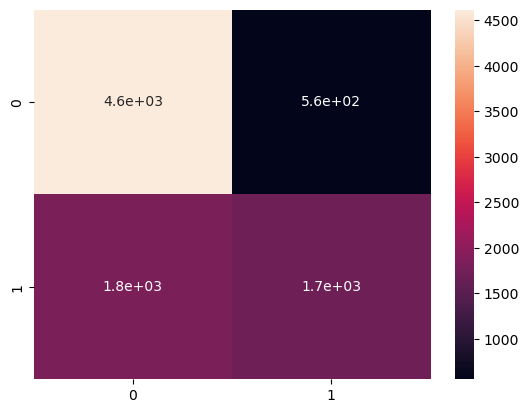

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.show() 

In [ ]:
# models = {
#     'DecisionTreeClassifier': DecisionTreeClassifier(),
#     'SVM': SVC(),
#     'RandomForestClassifier': RandomForestClassifier(),
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'XGBoost': xgb.XGBClassifier()
# }
# results = []
# for name, model in models.items():
#     pipeline = Pipeline([
#         ('classifier', model)
#     ])
#     pipeline.fit(X_train,y_train)
#     y_prediction = pipeline.predict(X_test)
#     results.append({
#         'model': name,
#         'accuracy': accuracy_score(y_test, y_prediction)
#     })
# results
## RandomForestClassifier is the most efficient of the list

[{'model': 'DecisionTreeClassifier', 'accuracy': 0.6448426372616586},
 {'model': 'SVM', 'accuracy': 0.611187686652883},
 {'model': 'RandomForestClassifier', 'accuracy': 0.7212267401791868},
 {'model': 'KNeighborsClassifier', 'accuracy': 0.5773030094187916},
 {'model': 'XGBoost', 'accuracy': 0.7183551573627384}]

In [ ]:
# models = {
#     'Linear Regression': LinearRegression(),
#     'Ridge Regression': Ridge(),
#     'Lasso Regression': Lasso(),
#     'Support Vector Regression': SVR(),
#     'Decision Tree Regression': DecisionTreeRegressor(),
#     'KNN Regression': KNeighborsRegressor(),
#     'Random Forest Regression': RandomForestRegressor(), 
#     'AdaBoost Regression': AdaBoostRegressor(),
# }

# results = []

# for name, model in models.items():
#     pipeline = Pipeline([
#         ('regressor', model)
#     ])
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     results.append({
#         'model':name,
#         'R2_score':r2_score(y_test,y_pred),
#         'RMSE':[mean_squared_error(y_test,y_pred)]
#     })
    
# results

## Demo

In [ ]:
# import joblib
# import gradio as gr

In [ ]:
# joblib.dump(best_model, 'heart_attack_prediction_model.joblib')

In [ ]:
# model = joblib.load('heart_attack_prediction_model.joblib')
# model

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        min_samples_split=3))])

In [ ]:
# def predict_heart_attack('age',
#  'gender',
#  'region',
#  'income_level',
#  'hypertension',
#  'diabetes',
#  'cholesterol_level',
#  'obesity',
#  'waist_circumference',
#  'family_history',
#  'smoking_status',
#  'alcohol_consumption',
#  'physical_activity',
#  'dietary_habits',
#  'air_pollution_exposure',
#  'stress_level',
#  'sleep_hours',
#  'blood_pressure_systolic',
#  'blood_pressure_diastolic',
#  'fasting_blood_sugar',
#  'cholesterol_hdl',
#  'cholesterol_ldl',
#  'triglycerides',
#  'EKG_results',
#  'previous_heart_disease',
#  'medication_usage',
#  'participated_in_free_screening',
#  'heart_attack'):
    